<a href="https://colab.research.google.com/github/bzhanglab/AutoRT/blob/master/example/Phosphorylation_experiment_specific_RT_prediction_using_AutoRT_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Experiment-specific RT prediction for phosphopeptides using AutoRT

In this notebook, I will walk you through an example of training a highly accurate experiment-specific RT prediction model for phosphopeptides using AutoRT on a small training dataset derived from a single-shot mouse phosphoproteomics experiment. The single-shot raw MS data (QE3_201029_OPL1025_FR_liver_TiOx_Urea_RNAB_A.raw) could be downloaded from PRIDE (https://www.ebi.ac.uk/pride/archive/projects/PXD023665). 

### Installation

#### Run AutoRT on Google Colab

Colab already has all the dependent libraries and packages installed, so we only need to download AutoRT from github.

In [ ]:
## install AutoRT
! git clone https://github.com/bzhanglab/AutoRT
! ls -l -t

Cloning into 'AutoRT'...
remote: Enumerating objects: 408, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 408 (delta 16), reused 27 (delta 12), pack-reused 376
Receiving objects: 100% (408/408), 1.32 GiB | 29.50 MiB/s, done.
Resolving deltas: 100% (180/180), done.
Checking out files: 100% (87/87), done.
total 8
drwxr-xr-x 6 root root 4096 Oct 10 22:41 AutoRT
drwxr-xr-x 1 root root 4096 Sep 30 17:12 sample_data


### Prepare training data





#### Phosphopeptide identification using MaxQuant:

We need to first perform peptide identification using MaxQuant. After MaxQuant analysis is done, we can find a file named "evidence.txt" in the "combined/txt/" folder generated by MaxQuant. This file ("evidence.txt") contains the identified phosphopeptides and peptide retention time information we need for RT model training. This file could be download at https://github.com/bzhanglab/AutoRT/blob/master/example/data/phosphorylation/PXD023665_mouse/evidence.txt .

More information about the data format in "evidence.txt" could be found at http://www.coxdocs.org/doku.php?id=maxquant:table:evidencetable.

#### Upload identification result file to Colab:

Upload the file "evidence.txt" to Google Colab using the upload function on the left side. After the file is uploaded, you will see the file in the current folder as shown below:

In [ ]:
# check the file in current folder
%ls -l

total 7000
drwxr-xr-x 6 root root    4096 Oct 10 22:41 AutoRT/
-rw-r--r-- 1 root root 7158891 Oct 10 22:41 evidence.txt
drwxr-xr-x 1 root root    4096 Sep 30 17:12 sample_data/


Load the data in file "evidence.txt": 

In [ ]:
import pandas as pd
evidence_df = pd.read_csv("evidence.txt",sep="\t")
print("The number of rows: %d" % (evidence_df.shape[0]))
evidence_df.head()

The number of rows: 7467


,Sequence,Length,Modifications,Modified sequence,Oxidation (M) Probabilities,Phospho (STY) Probabilities,Oxidation (M) Score Diffs,Phospho (STY) Score Diffs,Oxidation (M),Phospho (STY),Missed cleavages,Proteins,Leading proteins,Leading razor protein,Type,Raw file,MS/MS m/z,Charge,m/z,Mass,Resolution,Uncalibrated - Calibrated m/z [ppm],Uncalibrated - Calibrated m/z [Da],Mass error [ppm],Mass error [Da],Uncalibrated mass error [ppm],Uncalibrated mass error [Da],Max intensity m/z 0,Retention time,Retention length,Calibrated retention time,Calibrated retention time start,Calibrated retention time finish,Retention time calibration,Match time difference,Match m/z difference,Match q-value,Match score,Number of data points,Number of scans,Number of isotopic peaks,PIF,Fraction of total spectrum,Base peak fraction,PEP,MS/MS count,MS/MS scan number,Score,Delta score,Combinatorics,Intensity,Reverse,Potential contaminant,id,Protein group IDs,Peptide ID,Mod. peptide ID,MS/MS IDs,Best MS/MS,AIF MS/MS IDs,Oxidation (M) site IDs,Phospho (STY) site IDs
0,AAAASAAEAGIATPGTEDSDDALLK,25,Phospho (STY),_AAAASAAEAGIATPGTEDS(ph)DDALLK_,NaN,AAAASAAEAGIAT(0.013)PGT(0.036)EDS(0.95)DDALLK,NaN,AAAAS(-47.07)AAEAGIAT(-18.55)PGT(-14.16)EDS(14...,0,1,0,sp|O35226|PSMD4_MOUSE,sp|O35226|PSMD4_MOUSE,sp|O35226|PSMD4_MOUSE,MULTI-MSMS,QE3_201029_OPL1025_FR_liver_TiOx_Urea_RNAB_A,799.368042,3,799.367008,2395.07919,68971.137463,2.12330,0.001697,-0.046034,-0.000037,2.07730,0.001661,799.366459,80.505,0.36796,80.505,80.297,80.665,0.000000e+00,NaN,NaN,NaN,NaN,36.0,12.0,4.0,0,0,0,8.790300e-03,1.0,36364.0,56.366,48.079,4.0,4296400.0,NaN,NaN,0.0,193,0.0,0.0,0,0.0,NaN,NaN,431
1,AAAASAAEAGIATPGTEGERDSDDALLK,28,Phospho (STY),_AAAASAAEAGIATPGpTEGERDSDDALLK_,NaN,AAAASAAEAGIAT(0.005)PGT(0.497)EGERDS(0.497)DDALLK,NaN,AAAAS(-132.16)AAEAGIAT(-19.62)PGT(0)EGERDS(0)D...,0,1,1,tr|F7AI87|F7AI87_MOUSE,tr|F7AI87|F7AI87_MOUSE,tr|F7AI87|F7AI87_MOUSE,MULTI-MSMS,QE3_201029_OPL1025_FR_liver_TiOx_Urea_RNAB_A,913.758301,3,913.422064,2737.24436,64299.626154,1.10130,0.001006,0.177190,0.000162,1.27850,0.001168,913.756791,66.132,0.48024,66.132,65.875,66.356,0.000000e+00,NaN,NaN,NaN,NaN,55.0,16.0,5.0,0,0,0,3.374400e-11,2.0,28348.0,152.190,140.880,4.0,15214000.0,NaN,NaN,1.0,2830,1.0,1.0,1;2,2.0,NaN,NaN,5767;6754
2,AAAQYSSQKSVEER,14,Phospho (STY),_AAAQYSSQKpSVEER_,NaN,AAAQYSS(0.007)QKS(0.993)VEER,NaN,AAAQY(-92.19)S(-43.63)S(-21.8)QKS(21.8)VEER,0,1,1,tr|Q9CQ73|Q9CQ73_MOUSE,tr|Q9CQ73|Q9CQ73_MOUSE,tr|Q9CQ73|Q9CQ73_MOUSE,MULTI-MSMS,QE3_201029_OPL1025_FR_liver_TiOx_Urea_RNAB_A,545.245728,3,545.245436,1632.71448,84667.205685,0.95061,0.000518,-0.197730,-0.000108,0.75288,0.000411,545.245177,26.648,0.59071,26.648,26.493,27.084,0.000000e+00,NaN,NaN,NaN,NaN,48.0,20.0,5.0,0,0,0,1.446400e-07,1.0,5917.0,140.300,107.320,4.0,11217000.0,NaN,NaN,2.0,2894,2.0,2.0,3,3.0,NaN,NaN,5902
3,AAATEDATPAALEK,14,Phospho (STY),_AAATEDApTPAALEK_,NaN,AAATEDAT(1)PAALEK,NaN,AAAT(-60.08)EDAT(60.08)PAALEK,0,1,0,sp|O08705|NTCP_MOUSE,sp|O08705|NTCP_MOUSE,sp|O08705|NTCP_MOUSE,MULTI-MSMS,QE3_201029_OPL1025_FR_liver_TiOx_Urea_RNAB_A,719.826965,2,719.826704,1437.63885,74305.645991,1.23920,0.000892,-0.106390,-0.000077,1.13280,0.000815,719.826501,43.751,0.56218,43.751,43.455,44.017,7.105400e-15,NaN,NaN,NaN,NaN,49.0,19.0,4.0,0,0,0,4.501200e-07,2.0,15786.0,131.960,110.590,2.0,19702000.0,NaN,NaN,3.0,165,3.0,3.0,4;5,5.0,NaN,NaN,5968
4,AAATFNPELITHILDGSPENTR,22,Phospho (STY),_AAATFNPELITHILDGpSPENTR_,NaN,AAATFNPELIT(0.016)HILDGS(0.737)PENT(0.247)R,NaN,AAAT(-38.01)FNPELIT(-16.6)HILDGS(4.75)PENT(-4....,0,1,0,sp|Q9R0H0|ACOX1_MOUSE,sp|Q9R0H0|ACOX1_MOUSE,sp|Q9R0H0|ACOX1_MOUSE,MULTI-MSMS,QE3_201029_OPL1025_FR_liver_TiOx_Urea_RNAB_A,816.391479,3,816.391599,2446.15297,67806.550107,0.44807,0.000366,0.667680,0.000545,1.11580,0.000911,816.726558,115.100,0.35990,115.100,114.890,115.250,0.000000e+00,NaN,NaN,NaN,NaN,34.0,12.0,3.0,0,0,0,2.284800e-02,1.0,55661.0,43.732,35.113,4.0,8536200.0,NaN,NaN,4.0,2573,4.0,4.0,6,6.0,NaN,NaN,5099


#### Generate training data

Use the scripts in folder "AutoRT/example/scripts/" to process the file "evidence.txt" to generate training and testing files.

Running the following command lines will generate two files:
"train_data.tsv" (80% of peptides) and "test_data.tsv" (20% of peptides) in the current folder.

In [ ]:
! python AutoRT/example/scripts/process_mq_evidence.py -i evidence.txt -o formated_evidence.txt -m "Phospho (STY)" -f 1
## 0.2: the ratio of split for testing data
! Rscript AutoRT/example/scripts/generate_training_testing_data_for_single_shot_ptm.R formated_evidence.txt 0.2 ./

100% 12484/12484 [00:03<00:00, 3643.58it/s]
Total decoy or contaminant PSMs: 116
Low confident modified peptides: 2367
Low score peptides (< 0.000000): 0

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

`summarise()` has grouped output by 'x'. You can override using the `.groups` argument.
train data: 6115 
test data: 1529 
train data file: .//train_data.tsv 
test data file: .//test_data.tsv 


RT distributions of the training data and testing data are shown below. The unit of the RT in the data is in minutes.

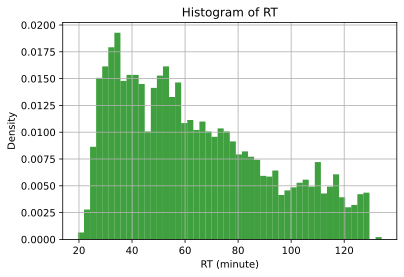

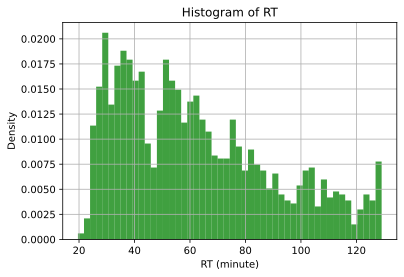

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
train_data = pd.read_csv("train_data.tsv",sep="\t",low_memory=False)
# the histogram of the data
plt.hist(train_data['y'], 50, density=True, facecolor='g', alpha=0.75)

plt.xlabel('RT (minute)')
plt.ylabel('Density')
plt.title('Histogram of RT')
plt.grid(True)
plt.show()

test_data = pd.read_csv("test_data.tsv",sep="\t",low_memory=False)
# the histogram of the data
plt.hist(test_data['y'], 50, density=True, facecolor='g', alpha=0.75)

plt.xlabel('RT (minute)')
plt.ylabel('Density')
plt.title('Histogram of RT')
plt.grid(True)
plt.show()


### Training


#### Pretrained PTM base model for phosphorylation:
The pretrained PTM base model for phosphorylation is available at **AutoRT/models/ptm_base_model/phosphorylation_sty/**. The PTM base model was trained using a large phosphoproteomics dataset. The training data for the base model training contains a fixed modification of Carbamidomethyl (C) and four variable modifications: Oxidation (M), Phosphorylation (S), Phosphorylation (T) and Phosphorylation (Y). In the PTM base model training, Oxidation (M), Phosphorylation (S), Phosphorylation (T) and Phosphorylation (Y) are represented as 1, 2, 3 and 4, respectively.

#### Experiment-specific RT model training:
To train a highly accurate experiment-specific RT prediction model, we use transfer learning strategy. In other words, we will fine-tune the PTM base model trained using a large public phosphoproteomics dataset to build an experiment-specific RT prediction model.

Below is the command line for training using transfer learning strategy. The trained model will be in the folder "tf_model/" (-o).


In [ ]:
! python AutoRT/autort.py train -i train_data.tsv -o tf_model/ -e 40 -b 64 -u m -m AutoRT/models/ptm_base_model/phosphorylation_sty/model.json -rlr -n 10

Scaling method: min_max
Step 1:

Load aa coding data from file AutoRT/models/ptm_base_model/phosphorylation_sty/aa.tsv
AA types: 25
Longest peptide in training data: 43

Use test file tf_model//step1/validation.tsv
Longest peptide in test data: 46

['1', '2', '3', '4', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
RT range: 0 - 135

X_train shape:
(5503, 60)
X_test shape:
(612, 60)
Modeling start ...
Use one GPU or no GPU!

Model training: 0
2021-10-10 22:44:19.730314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-10 22:44:20.209725: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-10 22:44:20.210653: I tensorflow/stream_executor/cud

After the training is done, the trained model is in the folder **tf_model/** (-o):

In [ ]:
! ls -l tf_model/

total 197196
-rw-r--r-- 1 root root      120 Oct 10 23:04 aa.tsv
-rw-r--r-- 1 root root 20405264 Oct 10 22:48 model_0.h5
-rw-r--r-- 1 root root 18264536 Oct 10 22:49 model_1.h5
-rw-r--r-- 1 root root 20559088 Oct 10 22:51 model_2.h5
-rw-r--r-- 1 root root 20559064 Oct 10 22:53 model_3.h5
-rw-r--r-- 1 root root 20405280 Oct 10 22:54 model_4.h5
-rw-r--r-- 1 root root 20251888 Oct 10 22:57 model_5.h5
-rw-r--r-- 1 root root 20558880 Oct 10 22:59 model_6.h5
-rw-r--r-- 1 root root 20251664 Oct 10 23:01 model_7.h5
-rw-r--r-- 1 root root 19557368 Oct 10 23:02 model_8.h5
-rw-r--r-- 1 root root 19557392 Oct 10 23:04 model_9.h5
-rw-r--r-- 1 root root      522 Oct 10 23:04 model_all.json
-rw-r--r-- 1 root root      594 Oct 10 23:13 model.json
-rw-r--r-- 1 root root   111978 Oct 10 23:13 models_combination_metrics.tsv
-rw-r--r-- 1 root root   551618 Oct 10 22:46 new_train_data.tsv
drwxr-xr-x 4 root root     4096 Oct 10 22:46 step1
-rw-r--r-- 1 root root    13260 Oct 10 23:04 test_0.csv
-rw-r--r-- 1

### Prediction

Now we can use the test data we generated previously to evaluate the performance of the newly trained RT model. 

The data in the test data file ("test_data.tsv") is shown below. In prediction, the column **x** is the only required column which contains the peptides. The column "y" is not required but if it's present in the file, AutoRT will output model performance metrics after the prediction is done.

In [ ]:
test_data = pd.read_csv("test_data.tsv",sep="\t")
test_data.head()

,x,raw_file,rt_range,rt,n,is_ptm,y
0,NQAGYFMLPTVITDIKDESR,QE3_201029_OPL1025_FR_liver_TiOx_Urea_RNAB_A,0.000,105.780,1,N,105.780
1,ELGEHGL4EYTELK,QE3_201029_OPL1025_FR_liver_TiOx_Urea_RNAB_A,0.000,68.931,1,Y,68.931
2,RE3DGSETPEPFAAEAK,QE3_201029_OPL1025_FR_liver_TiOx_Urea_RNAB_A,0.012,48.037,2,Y,48.037
3,ADIVENQVMDTR,QE3_201029_OPL1025_FR_liver_TiOx_Urea_RNAB_A,0.000,50.631,1,N,50.631
4,AP2VTSAAH2GYR,QE3_201029_OPL1025_FR_liver_TiOx_Urea_RNAB_A,0.000,37.648,1,Y,37.648


Below is the command line to perform RT prediction using the model we just trained. The prediction result will be in the folder "tf_prediction/".

In [ ]:
! python AutoRT/autort.py predict -t test_data.tsv -s tf_model/model.json -o tf_prediction/ -p test

Average ...
Load aa coding data from file tf_model/aa.tsv
AA types: 25
Longest peptide in input data: 50

['1', '2', '3', '4', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

Deep learning model: 0

Deep learning model: 1
2021-10-10 23:14:04.933265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-10 23:14:04.944554: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-10 23:14:04.945530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-10 23:14:04.947378: I tensorflow/stream_executor/cuda/cud

The prediction result is in the file **tf_prediction/test.tsv**. The values in the column **y_pred** are predicted RTs. Other files in the same folder are intermediate files which are not useful to users. 

In [ ]:
! ls -l tf_prediction/

total 412
-rw-r--r-- 1 root root  34960 Oct 10 23:14 test_1.csv
-rw-r--r-- 1 root root   6244 Oct 10 23:14 test_1.npy
-rw-r--r-- 1 root root  34945 Oct 10 23:14 test_2.csv
-rw-r--r-- 1 root root   6244 Oct 10 23:14 test_2.npy
-rw-r--r-- 1 root root  34959 Oct 10 23:14 test_5.csv
-rw-r--r-- 1 root root   6244 Oct 10 23:14 test_5.npy
-rw-r--r-- 1 root root  35005 Oct 10 23:14 test_6.csv
-rw-r--r-- 1 root root   6244 Oct 10 23:14 test_6.npy
-rw-r--r-- 1 root root  34980 Oct 10 23:14 test_7.csv
-rw-r--r-- 1 root root   6244 Oct 10 23:14 test_7.npy
-rw-r--r-- 1 root root  34444 Oct 10 23:14 test_evaluate.csv
-rw-r--r-- 1 root root 157568 Oct 10 23:14 test.tsv


In [ ]:
pred_data = pd.read_csv("tf_prediction/test.tsv",sep="\t")
pred_data.head()

Now we can look at the performance of the RT prediction.

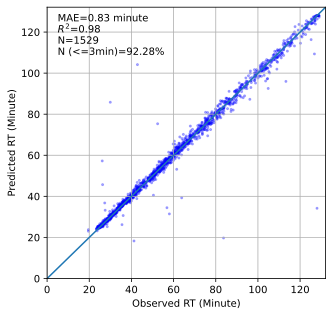

In [ ]:
import sklearn
import scipy
from sklearn.model_selection import train_test_split


pred_data = pd.read_csv("tf_prediction/test.tsv",sep="\t")
pred_data.head()

cor = scipy.stats.pearsonr(pred_data['y'], pred_data['y_pred'])[0]
mae = sklearn.metrics.median_absolute_error(pred_data['y'], pred_data['y_pred'])
r2 = sklearn.metrics.r2_score(pred_data['y'], pred_data['y_pred'])

n30 = np.sum(np.abs(pred_data['y'] - pred_data['y_pred'])<=3)

plt.rcParams['figure.figsize'] = [5, 5]
plt.scatter(pred_data['y'], pred_data['y_pred'],s=4, c="blue", alpha=0.3)
plt.text(5, np.max(pred_data['y_pred'])*0.85, "MAE="+"{:.2f}".format(mae)+" minute\n$R^2$="+"{:.2f}".format(r2)+"\nN="+str(pred_data.shape[0])+"\nN (<=3min)="+"{:.2f}%".format(100*n30/pred_data.shape[0]))
plt.plot( [0,140],[0,140] )
plt.xlabel('Observed RT (Minute)')
plt.ylabel('Predicted RT (Minute)')
plt.xlim(0,np.max(pred_data['y_pred'])+4)
plt.ylim(0,np.max(pred_data['y_pred'])+4)
plt.grid(True)
plt.show()

### Download trained model

We first generate a tar.gz file which contains the trained model files. Then we download the tar.gz file using the download function provided by Colab on the left side.

In [ ]:
! tar czf trained_model.tar.gz tf_model/